# Volcano plot

In [7]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [6]:
# Load packages
library(dplyr)
library(ggplot2)

# Install ggrepel package if needed
# install.packages("devtools")
# devtools::install_github("slowkow/ggrepel")
library(ggrepel) #To be able to make ggplot without overlapping labeling
library(glue)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Read data from the web
res_file_name = "../../output/cellNorm_one_way_ANOVA/simple_one_wayANOVA_hMinImp_cellNorm_groupFil0.3_HILICpos_fullreport.csv"
annot_file_name = "../../input/HILICpos_mzML/asari_project_output_727153535/Feature_annotation.tsv"
res_df = read.table(res_file_name, row.names = 1,header=TRUE, sep = ',')

In [4]:
head(res_df)

,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,⋯,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,85.0044,26.00,19.67,28.11,0,2003055,0.96,0.93,106,23,⋯,16.44929,15.64991,15.73690,15.31941,13.75765,16.00143,15.45488,16.25446,16.29809,16.52315
F100,130.9851,25.74,19.67,28.89,1936,3512837,1.00,0.97,217,24,⋯,16.22119,15.98205,15.93704,15.55304,13.12585,18.31586,18.61565,17.66144,17.55834,17.36552
F10000,393.2598,422.45,419.56,429.02,8551,3235844,1.00,0.90,148,17,⋯,15.59808,13.16461,13.16461,13.16461,18.15472,16.85217,18.32359,19.59158,16.12541,14.16461
F10004,393.2680,482.62,478.42,487.62,8553,1092807,0.91,0.97,51,11,⋯,16.86887,14.94052,14.94052,14.94052,18.17618,17.52588,18.64910,16.32349,15.94052,15.99033
F10006,409.2267,310.52,291.08,330.49,8979,10810474,1.00,0.95,161,24,⋯,19.18714,17.83219,17.71720,17.61735,19.80364,19.37064,19.52701,17.48562,18.17996,18.92816
F10007,409.2267,348.62,344.16,364.12,8979,2149563,1.00,0.90,69,24,⋯,13.61873,13.68497,12.38662,13.36999,14.18547,15.08910,15.69550,17.59065,16.99836,17.16847


-------

-------

-------

## Create output directory

In [9]:
out_dir = "../../output/cellNorm_one_way_ANOVA/volcano_plot/"
dir.create(out_dir)

In [10]:
head(res_df,2)

,mz,rtime,rtime_left_base,rtime_right_base,parent_masstrack_id,peak_area,cSelectivity,goodness_fitting,snr,detection_counts,Naive_percNA,Naive_mean,R5neg_percNA,R5neg_mean,R5pos_percNA,R5pos_mean,gMean_Naive,gMean_R5neg,gMean_R5pos,log2FC_R5negvsNaive,log2FC_R5posvsNaive,log2FC_R5posvsR5neg,f_score,pval,padj,Tpadj_R5neg.Naive,Tpadj_R5pos.Naive,Tpadj_R5pos.R5neg,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2,highlight
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
F3564,300.9321,82.79,62.26,135.82,6027,4098514,0.98,0.81,29,7,0,648614.3,1,NA,0,774350.3,19.30187,13.24934,20.44786,-6.052537,1.145987,7.198524,1055.6476,2.275671e-08,9.944682e-05,1.219980e-07,0.001200683,2.669532e-08,19.40898,19.12988,19.36675,13.24934,13.24934,13.24934,20.76028,20.11357,20.46973,NA,14.24934,NA,
F9521,391.9705,35.46,32.83,42.82,8506,7719760,0.94,0.78,31,6,1,NA,0,814128.2,1,NA,17.27472,18.33431,17.27472,1.059592,0.000000,-1.059592,832.8425,4.623708e-08,1.010280e-04,1.379671e-07,1.000000000,1.379671e-07,17.27472,17.27472,17.27472,18.32695,18.27472,18.40127,17.27472,17.27472,17.27472,NA,NA,NA,


------

------

------

------

------

# Volcano plot
## log2FC R5pos vs R5neg

In [18]:
padj_colname = 'Tpadj_R5pos.R5neg'
log2FC_colname = 'log2FC_R5posvsR5neg'
contrast = "R5pos vs. R5neg"

In [34]:
want2annotate_feature_name = TRUE
topN = 600

select_topN2present <- function(res_df, annot_df, topN, padj_label) {
    res_df = res_df %>% arrange_(padj_colname) 
    featIDs = rownames(res_df[1:topN,])
    annot_list = list()
    res_df['highlight'] = ""
    for (featID in featIDs) {
        res_df[featID,'highlight'] = annot_df[annot_df['X.peak.id_number']==featID,'name_1st_guess'][1]
    }
    
    return(res_df)
}

if(want2annotate_feature_name) {
    annot_df = read.csv(annot_file_name, sep = '\t') #somehow only dplyr read.csv works 
    res_df = select_topN2present(res_df, annot_df, topN)
}

## Volcano plot function

In [31]:
volcano_plot <- function(res_df = res_df,
                            padj_colname = padj_colname,
                            log2FC_colname = log2FC_colname,
                            p_cut_off = p_cut_off,
                            log2FC_cut_off = log2FC_cut_off,
                            xlab = xlab,
                            ylab = 'log10(FDR)',
                            xlim = xlim,
                            ylim = ylim,
                            highlight_text = FALSE,
                            fig_width = 8,
                            fig_height = 8,
                            text_size = 20,
                            legend_size = 20,
                            axis_title_size = 20,
                            output_dir = "",
                            pdf_prefix = 'test',
                            show_plot = TRUE) {
    
    colnames(res_df)
    res_df = mutate(res_df, 
                     Label = ifelse((res_df[,padj_colname] < p_cut_off) & (abs(res_df[,log2FC_colname]) > 1),  # Label is the column that distinguish the coloring
                                  "Significant", 
                                  "Not Sign.")) #mutate is a good function 

    res_df$log10padj = -log(res_df[,padj_colname],10)
    print(paste0("range of log10padj: ", range(res_df$log10padj),'\n', "range of log2FC: ", range(res_df$log2FC)))
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)
    
    hist(res_df[,log2FC_colname], breaks =30)
    
    p = ggplot( res_df, 
                aes_string(log2FC_colname,"log10padj")) +
                geom_point(aes(col=Label), alpha = 0.5) +
                scale_color_manual(values=c("#888888","#ff0000")) +
                xlim(xlim) + 
                ylim(ylim) + 
                xlab(xlab) +
                ylab(ylab) +
                
                theme(
                      panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
                      panel.border = element_rect(fill = NA),
                      #panel.grid.minor = element_blank(),
                      panel.background = element_rect(fill = "transparent",colour = NA),
                      plot.background = element_rect(fill = "transparent",colour = NA),
                      axis.text = element_text(size = text_size, colour="black"),
                      axis.text.x = element_text(colour="black"),
                      legend.text= element_text(size = legend_size),
                      legend.title = element_text(size = legend_size),
                      axis.title = element_text(size = axis_title_size)
                    )
    if(highlight_text == TRUE) {
        print("With highlighted text")
        p = p + geom_text_repel(data = filter(res_df, highlight != ""), aes(label = highlight))
    }
    
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, 
                             glue("volcano_plot",
                                                pdf_prefix,".pdf")), 
                   width = fig_width, 
                   height = fig_height)
        }
}

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"                
[2] "range of log10padj: 7.57356493459597\nrange of log2FC: -Inf"


Warning message:
“Removed 22 rows containing missing values (geom_point).”
Warning message:
“Removed 22 rows containing missing values (geom_point).”


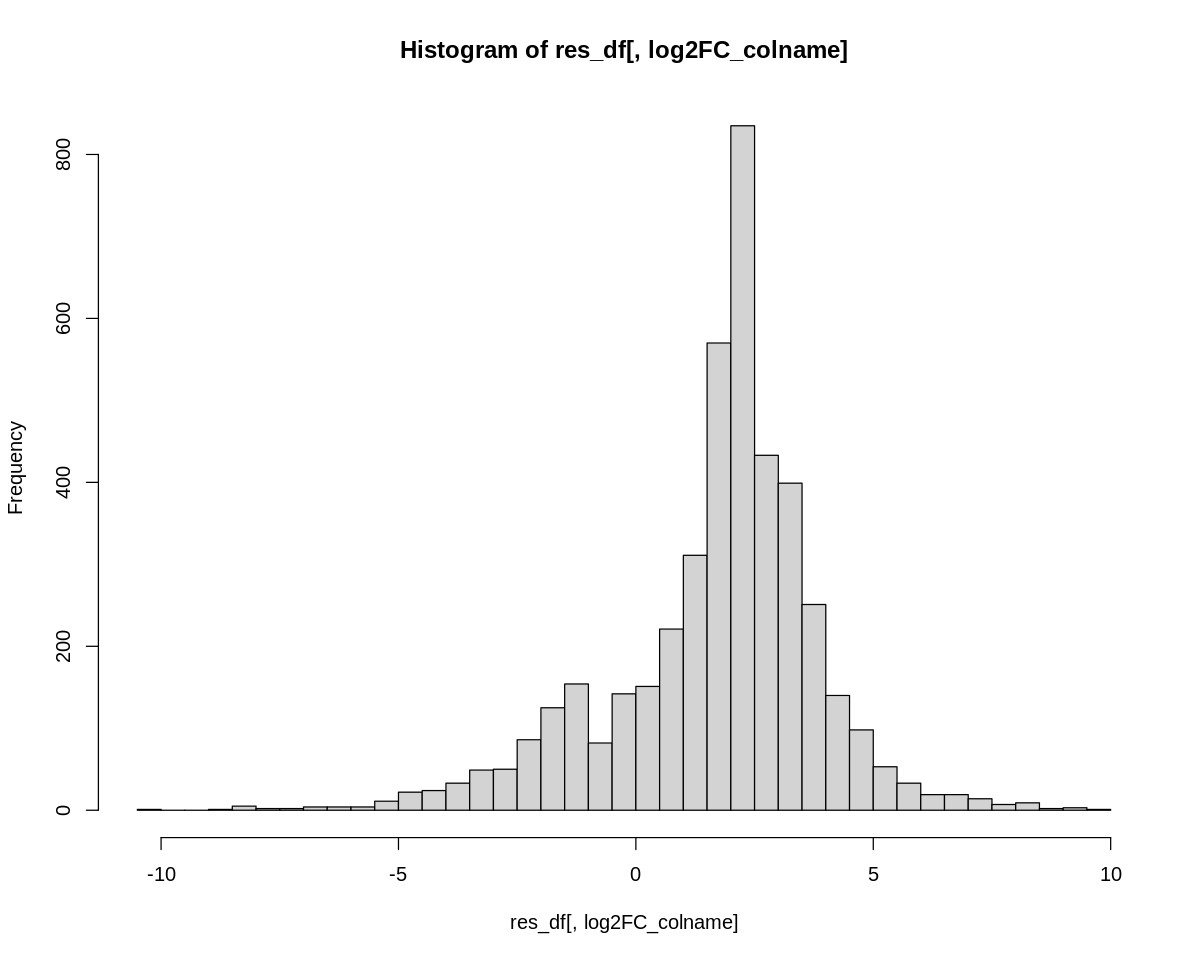

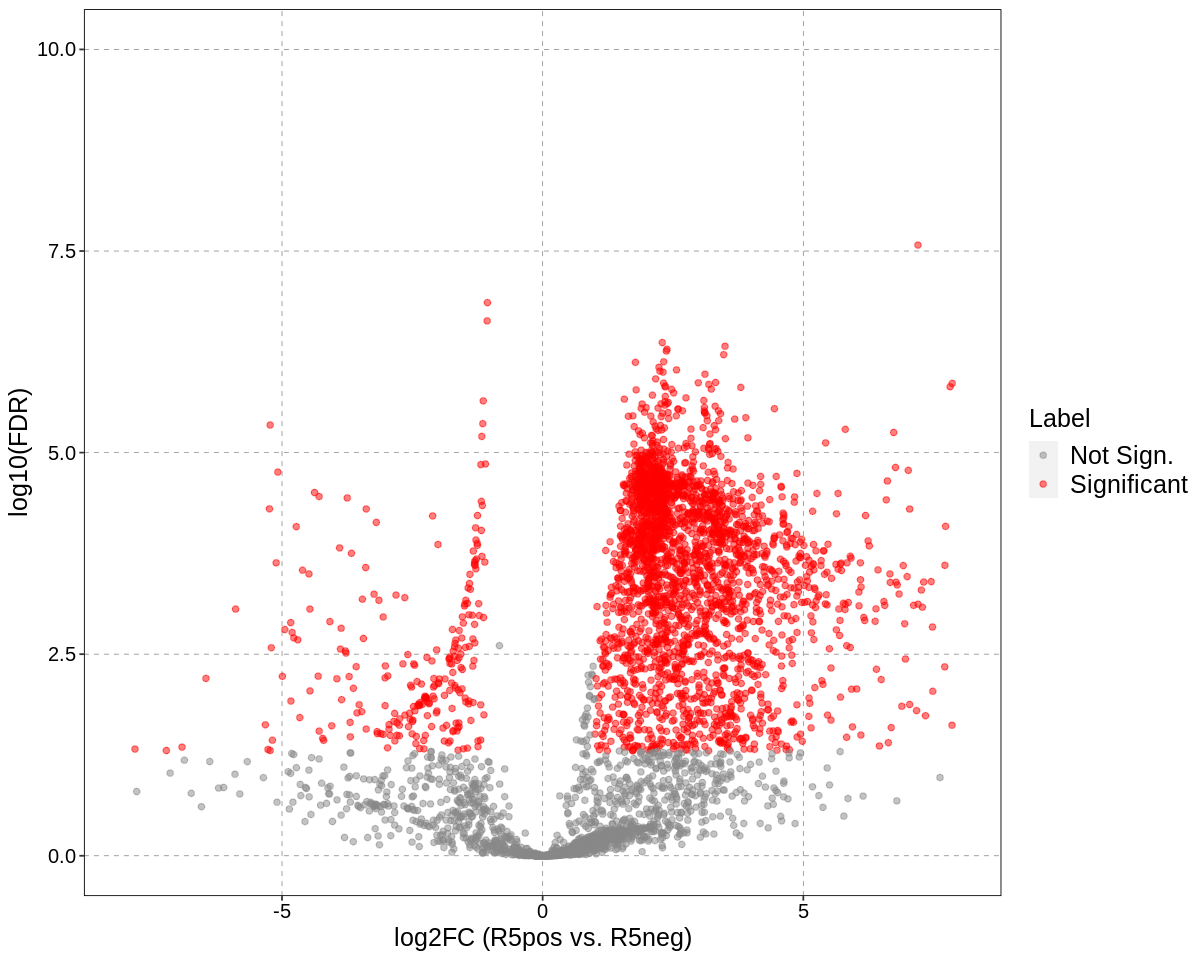

In [32]:
volcano_plot(res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight = FALSE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = 'contrast',
                show_plot = TRUE)

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"                
[2] "range of log10padj: 7.57356493459597\nrange of log2FC: -Inf"
[1] "With highlighted text"


Warning message:
“Removed 22 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 151 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 22 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 148 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


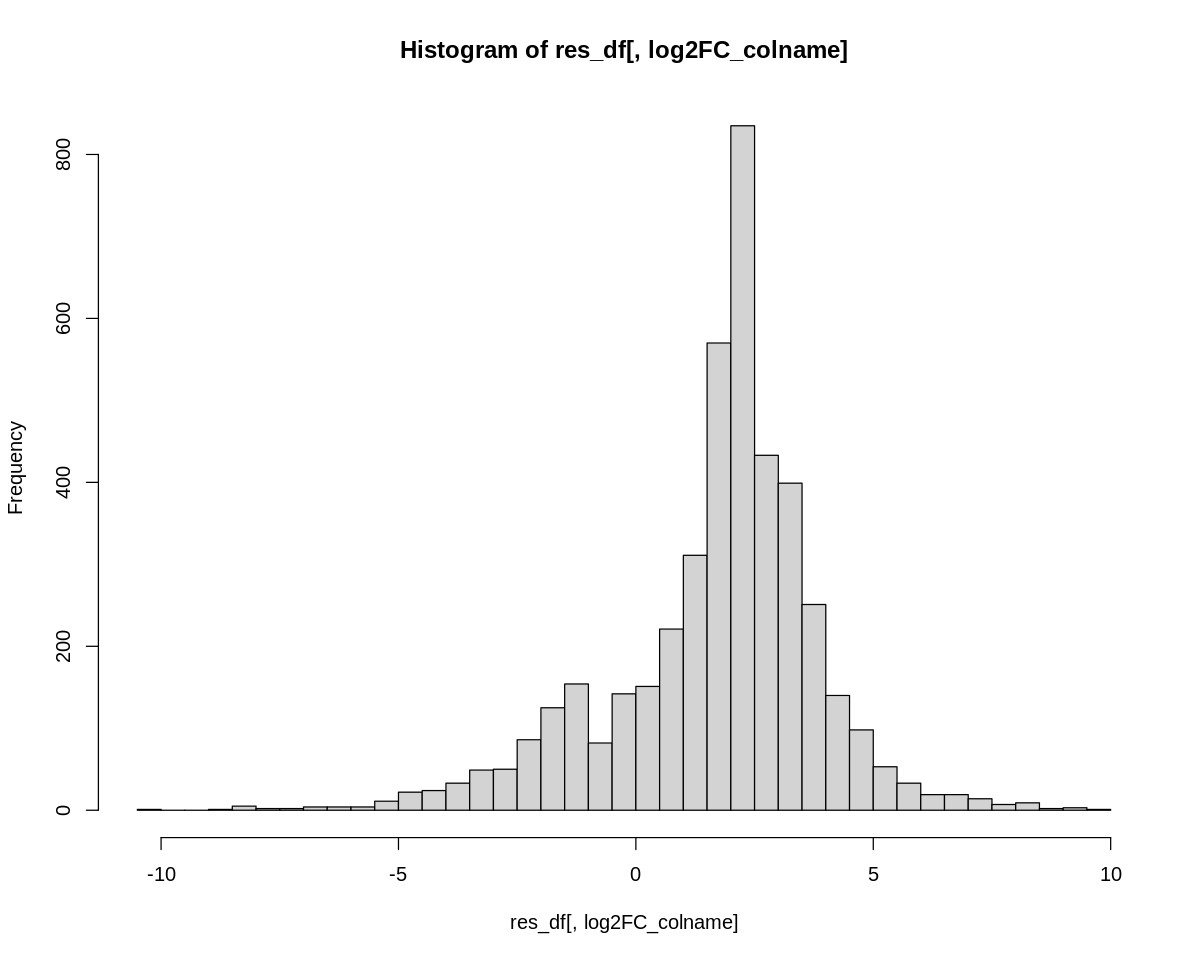

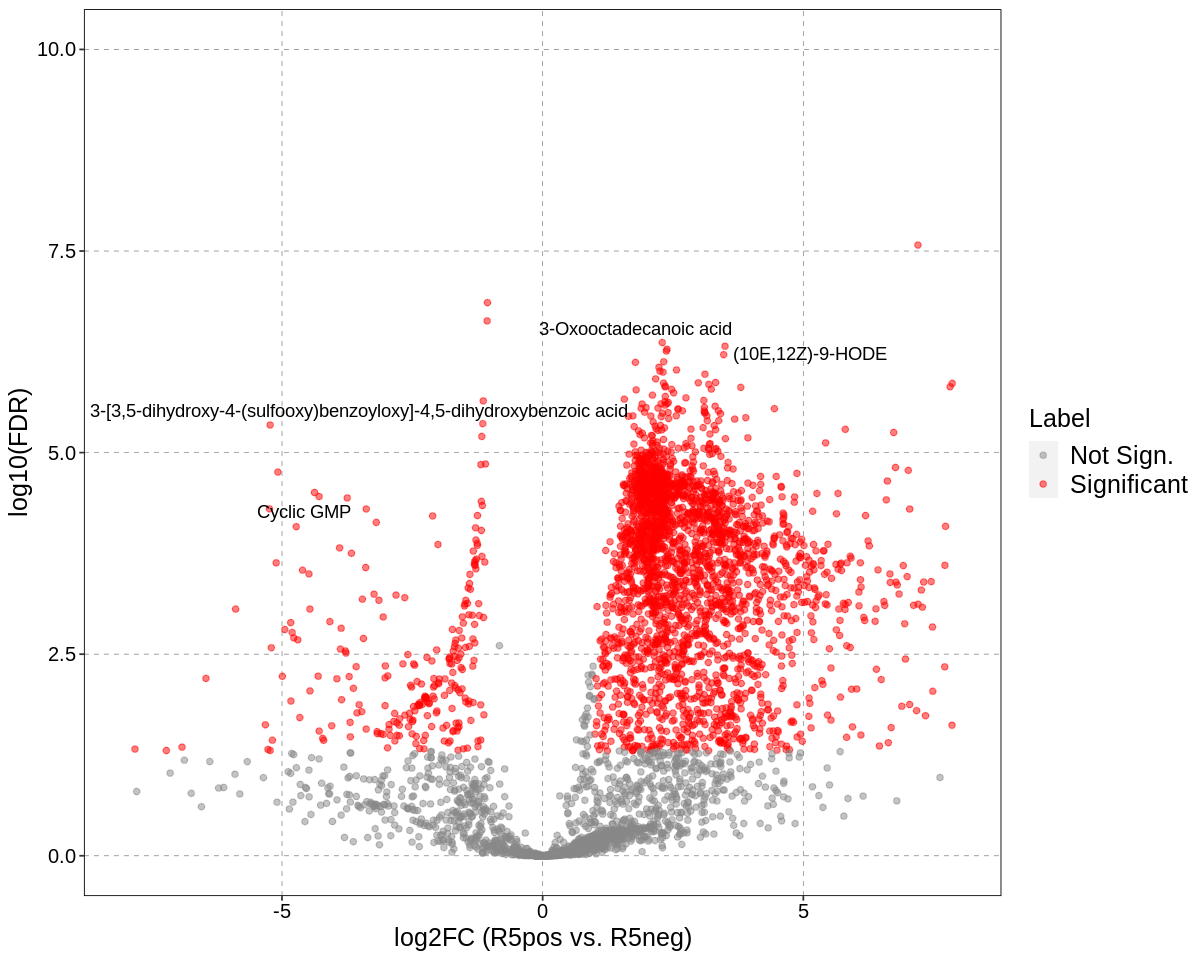

In [35]:
volcano_plot(   res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight_text = TRUE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = glue('contrast',"highlight"),
                show_plot = TRUE)

--------

------

# Volcano plot
## log2FC R5pos vs Naive

In [36]:
padj_colname = 'Tpadj_R5pos.Naive'
log2FC_colname = 'log2FC_R5posvsNaive'
contrast = "R5pos vs. Naive"

In [37]:
want2annotate_feature_name = TRUE
topN = 600

select_topN2present <- function(res_df, annot_df, topN, padj_label) {
    res_df = res_df %>% arrange_(padj_colname) 
    featIDs = rownames(res_df[1:topN,])
    annot_list = list()
    res_df['highlight'] = ""
    for (featID in featIDs) {
        res_df[featID,'highlight'] = annot_df[annot_df['X.peak.id_number']==featID,'name_1st_guess'][1]
    }
    
    return(res_df)
}

if(want2annotate_feature_name) {
    annot_df = read.csv(annot_file_name, sep = '\t') #somehow only dplyr read.csv works 
    res_df = select_topN2present(res_df, annot_df, topN)
}

## Volcano plot function

In [38]:
volcano_plot <- function(res_df = res_df,
                            padj_colname = padj_colname,
                            log2FC_colname = log2FC_colname,
                            p_cut_off = p_cut_off,
                            log2FC_cut_off = log2FC_cut_off,
                            xlab = xlab,
                            ylab = 'log10(FDR)',
                            xlim = xlim,
                            ylim = ylim,
                            highlight_text = FALSE,
                            fig_width = 8,
                            fig_height = 8,
                            text_size = 20,
                            legend_size = 20,
                            axis_title_size = 20,
                            output_dir = "",
                            pdf_prefix = 'test',
                            show_plot = TRUE) {
    
    colnames(res_df)
    res_df = mutate(res_df, 
                     Label = ifelse((res_df[,padj_colname] < p_cut_off) & (abs(res_df[,log2FC_colname]) > 1),  # Label is the column that distinguish the coloring
                                  "Significant", 
                                  "Not Sign.")) #mutate is a good function 

    res_df$log10padj = -log(res_df[,padj_colname],10)
    print(paste0("range of log10padj: ", range(res_df$log10padj),'\n', "range of log2FC: ", range(res_df$log2FC)))
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)
    
    hist(res_df[,log2FC_colname], breaks =30)
    
    p = ggplot( res_df, 
                aes_string(log2FC_colname,"log10padj")) +
                geom_point(aes(col=Label), alpha = 0.5) +
                scale_color_manual(values=c("#888888","#ff0000")) +
                xlim(xlim) + 
                ylim(ylim) + 
                xlab(xlab) +
                ylab(ylab) +
                
                theme(
                      panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
                      panel.border = element_rect(fill = NA),
                      #panel.grid.minor = element_blank(),
                      panel.background = element_rect(fill = "transparent",colour = NA),
                      plot.background = element_rect(fill = "transparent",colour = NA),
                      axis.text = element_text(size = text_size, colour="black"),
                      axis.text.x = element_text(colour="black"),
                      legend.text= element_text(size = legend_size),
                      legend.title = element_text(size = legend_size),
                      axis.title = element_text(size = axis_title_size)
                    )
    if(highlight_text == TRUE) {
        print("With highlighted text")
        p = p + geom_text_repel(data = filter(res_df, highlight != ""), aes(label = highlight))
    }
    
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, 
                             glue("volcano_plot",
                                                pdf_prefix,".pdf")), 
                   width = fig_width, 
                   height = fig_height)
        }
}

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"               
[2] "range of log10padj: 6.6183508153163\nrange of log2FC: -Inf"


Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


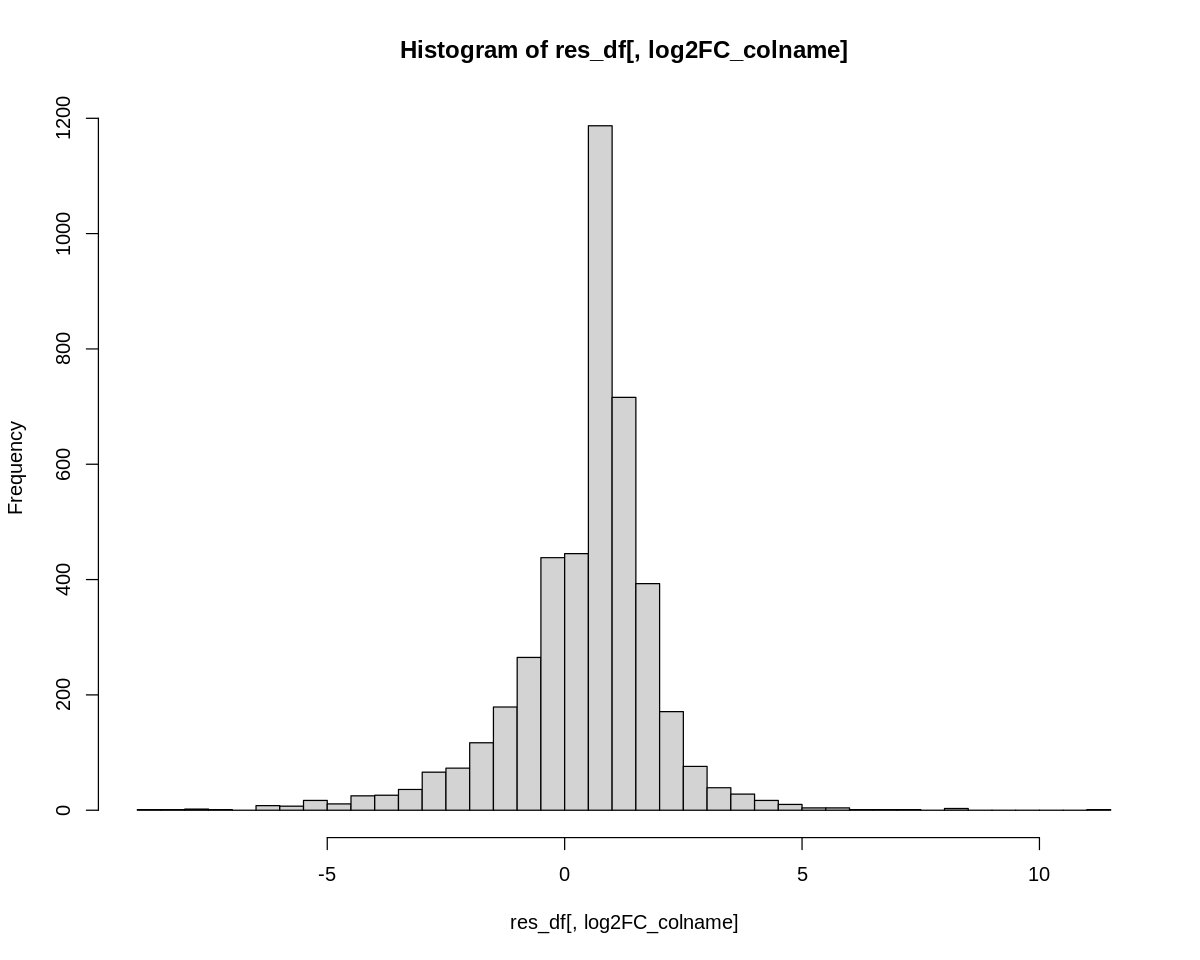

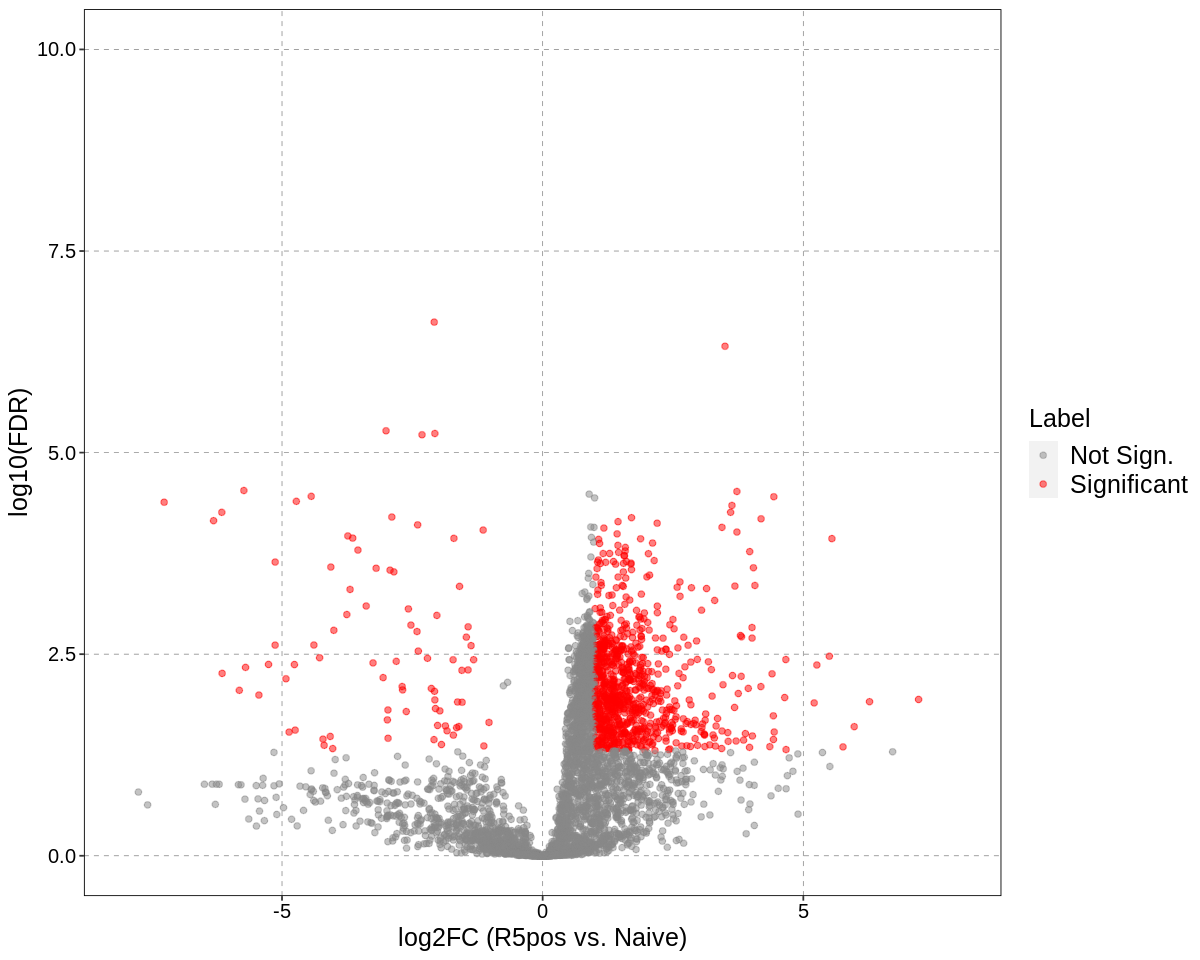

In [39]:
volcano_plot(res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight = FALSE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = 'contrast',
                show_plot = TRUE)

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"               
[2] "range of log10padj: 6.6183508153163\nrange of log2FC: -Inf"
[1] "With highlighted text"


Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 140 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 139 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


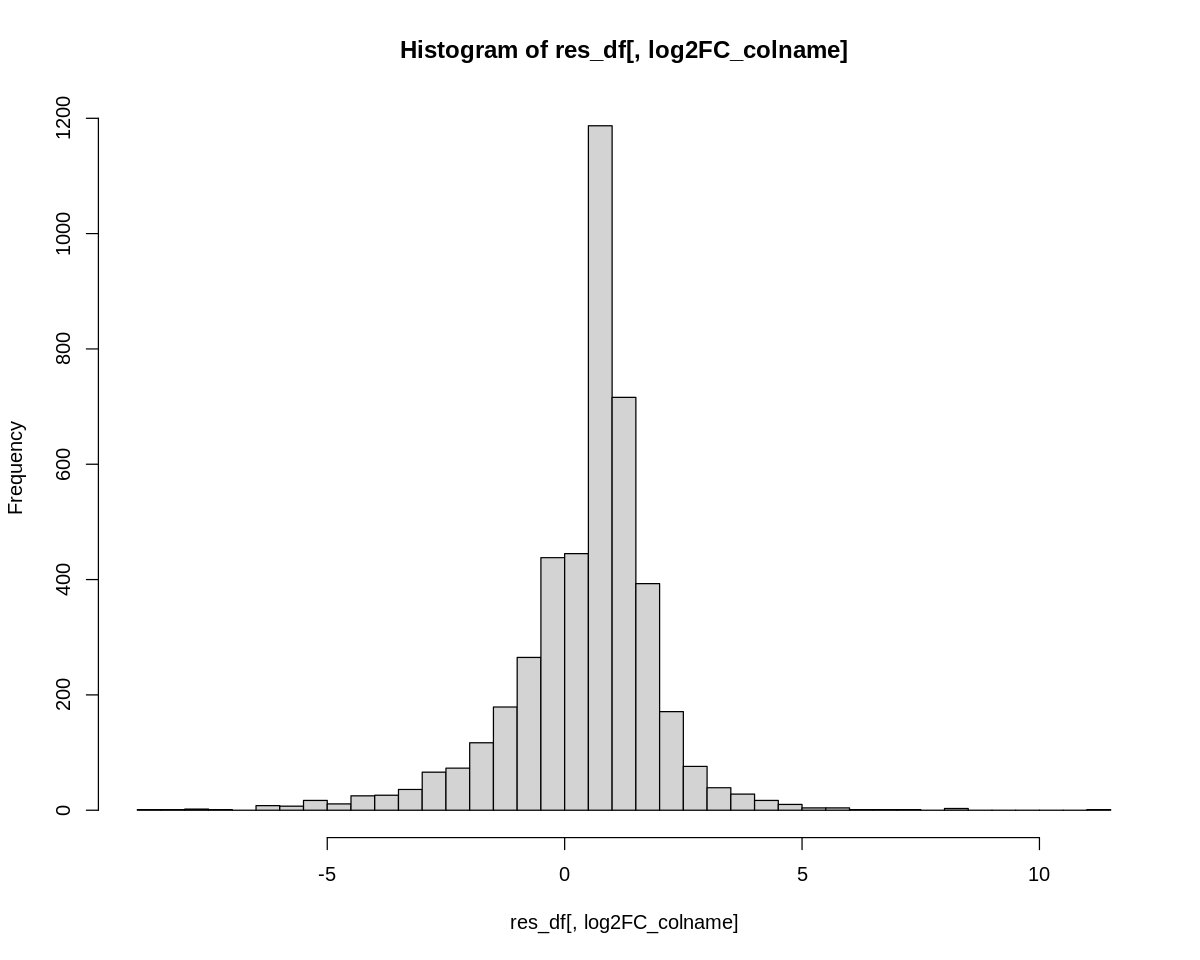

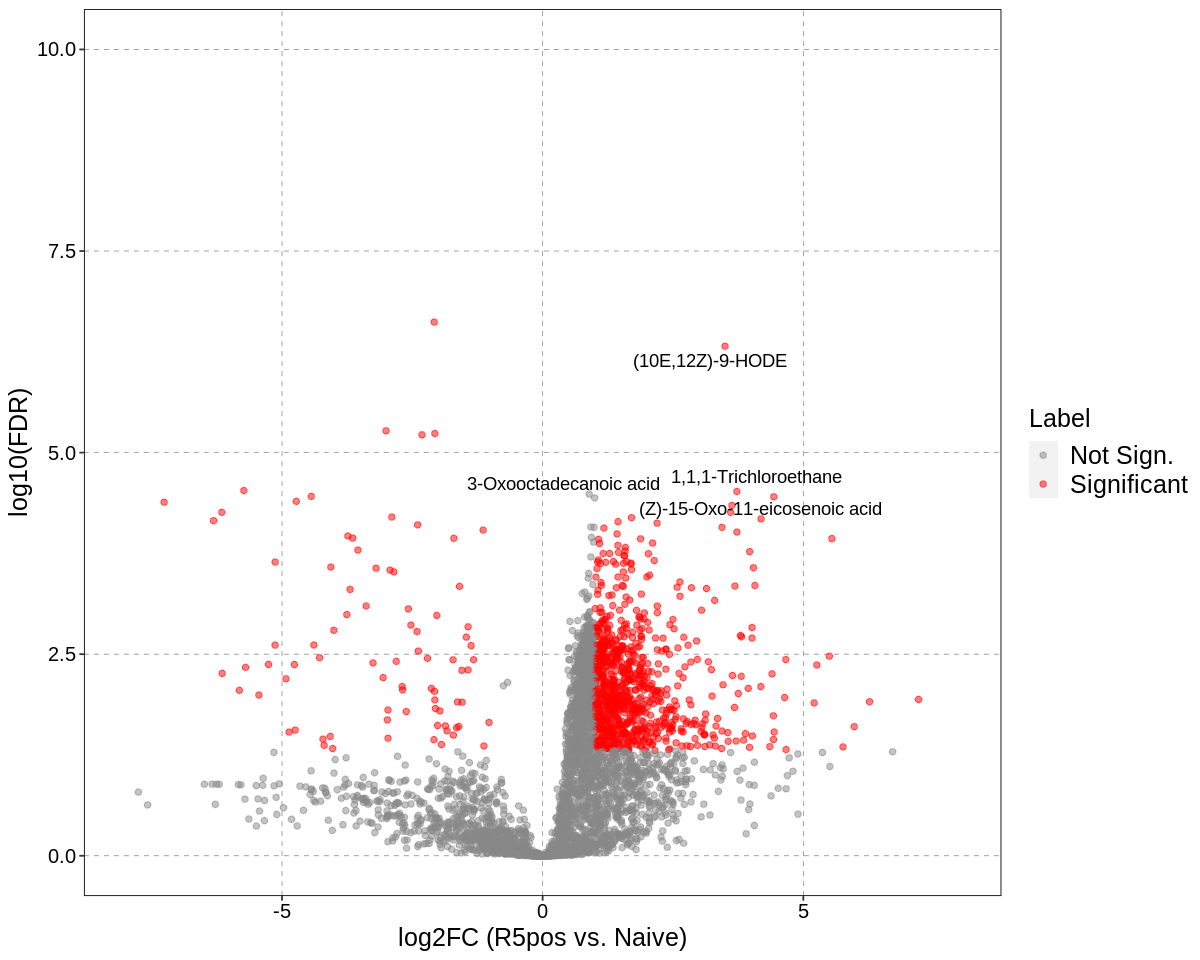

In [40]:
volcano_plot(   res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight_text = TRUE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = glue('contrast',"highlight"),
                show_plot = TRUE)

-----

-----

-----

-----

# Volcano plot
## log2FC R5neg vs Naive

In [41]:
padj_colname = 'Tpadj_R5neg.Naive'
log2FC_colname = 'log2FC_R5negvsNaive'
contrast = "R5neg vs. Naive"

In [42]:
want2annotate_feature_name = TRUE
topN = 600

select_topN2present <- function(res_df, annot_df, topN, padj_label) {
    res_df = res_df %>% arrange_(padj_colname) 
    featIDs = rownames(res_df[1:topN,])
    annot_list = list()
    res_df['highlight'] = ""
    for (featID in featIDs) {
        res_df[featID,'highlight'] = annot_df[annot_df['X.peak.id_number']==featID,'name_1st_guess'][1]
    }
    
    return(res_df)
}

if(want2annotate_feature_name) {
    annot_df = read.csv(annot_file_name, sep = '\t') #somehow only dplyr read.csv works 
    res_df = select_topN2present(res_df, annot_df, topN)
}

## Volcano plot function

In [43]:
volcano_plot <- function(res_df = res_df,
                            padj_colname = padj_colname,
                            log2FC_colname = log2FC_colname,
                            p_cut_off = p_cut_off,
                            log2FC_cut_off = log2FC_cut_off,
                            xlab = xlab,
                            ylab = 'log10(FDR)',
                            xlim = xlim,
                            ylim = ylim,
                            highlight_text = FALSE,
                            fig_width = 8,
                            fig_height = 8,
                            text_size = 20,
                            legend_size = 20,
                            axis_title_size = 20,
                            output_dir = "",
                            pdf_prefix = 'test',
                            show_plot = TRUE) {
    
    colnames(res_df)
    res_df = mutate(res_df, 
                     Label = ifelse((res_df[,padj_colname] < p_cut_off) & (abs(res_df[,log2FC_colname]) > 1),  # Label is the column that distinguish the coloring
                                  "Significant", 
                                  "Not Sign.")) #mutate is a good function 

    res_df$log10padj = -log(res_df[,padj_colname],10)
    print(paste0("range of log10padj: ", range(res_df$log10padj),'\n', "range of log2FC: ", range(res_df$log2FC)))
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)
    
    hist(res_df[,log2FC_colname], breaks =30)
    
    p = ggplot( res_df, 
                aes_string(log2FC_colname,"log10padj")) +
                geom_point(aes(col=Label), alpha = 0.5) +
                scale_color_manual(values=c("#888888","#ff0000")) +
                xlim(xlim) + 
                ylim(ylim) + 
                xlab(xlab) +
                ylab(ylab) +
                
                theme(
                      panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
                      panel.border = element_rect(fill = NA),
                      #panel.grid.minor = element_blank(),
                      panel.background = element_rect(fill = "transparent",colour = NA),
                      plot.background = element_rect(fill = "transparent",colour = NA),
                      axis.text = element_text(size = text_size, colour="black"),
                      axis.text.x = element_text(colour="black"),
                      legend.text= element_text(size = legend_size),
                      legend.title = element_text(size = legend_size),
                      axis.title = element_text(size = axis_title_size)
                    )
    if(highlight_text == TRUE) {
        print("With highlighted text")
        p = p + geom_text_repel(data = filter(res_df, highlight != ""), aes(label = highlight))
    }
    
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, 
                             glue("volcano_plot",
                                                pdf_prefix,".pdf")), 
                   width = fig_width, 
                   height = fig_height)
        }
}

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"                
[2] "range of log10padj: 6.91364711849783\nrange of log2FC: -Inf"


Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


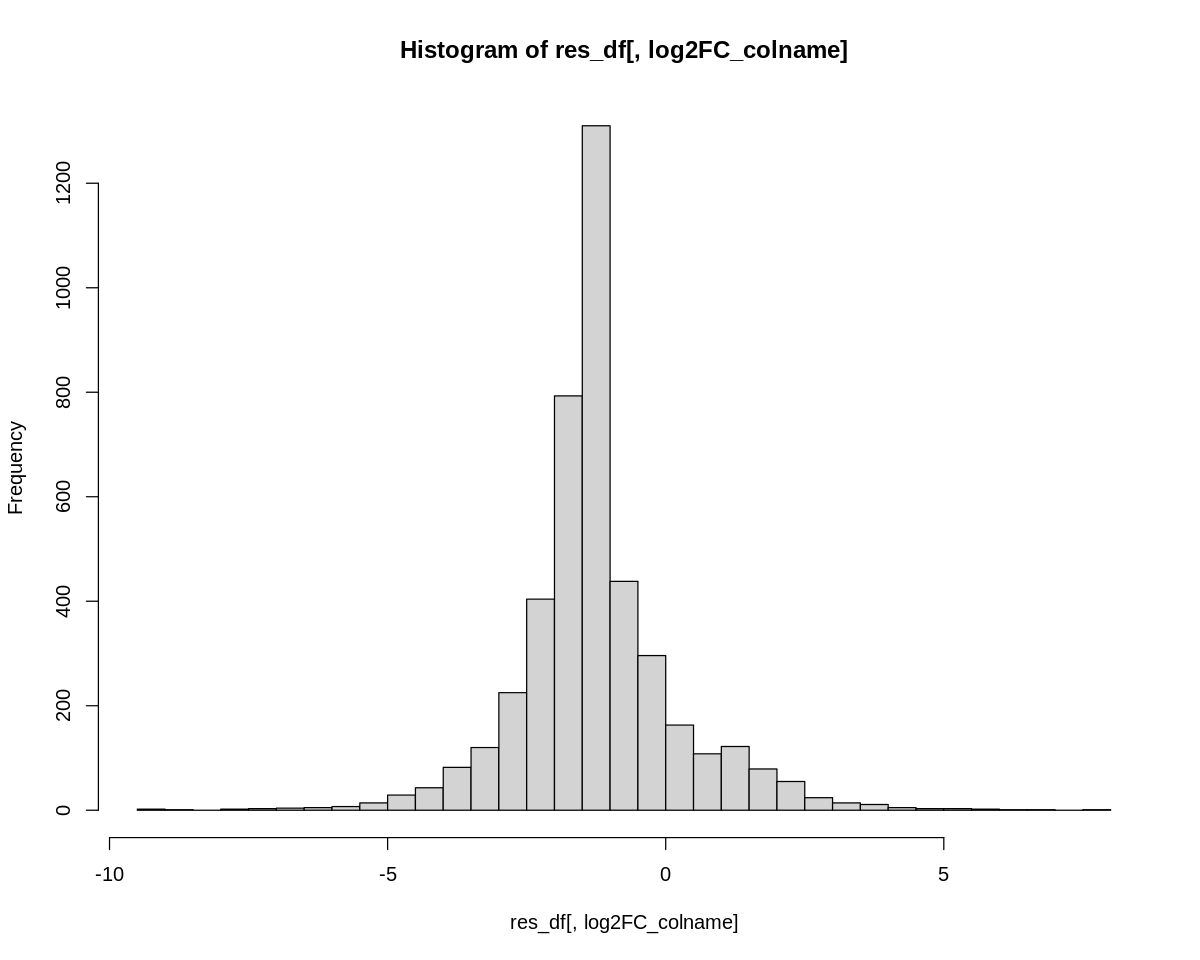

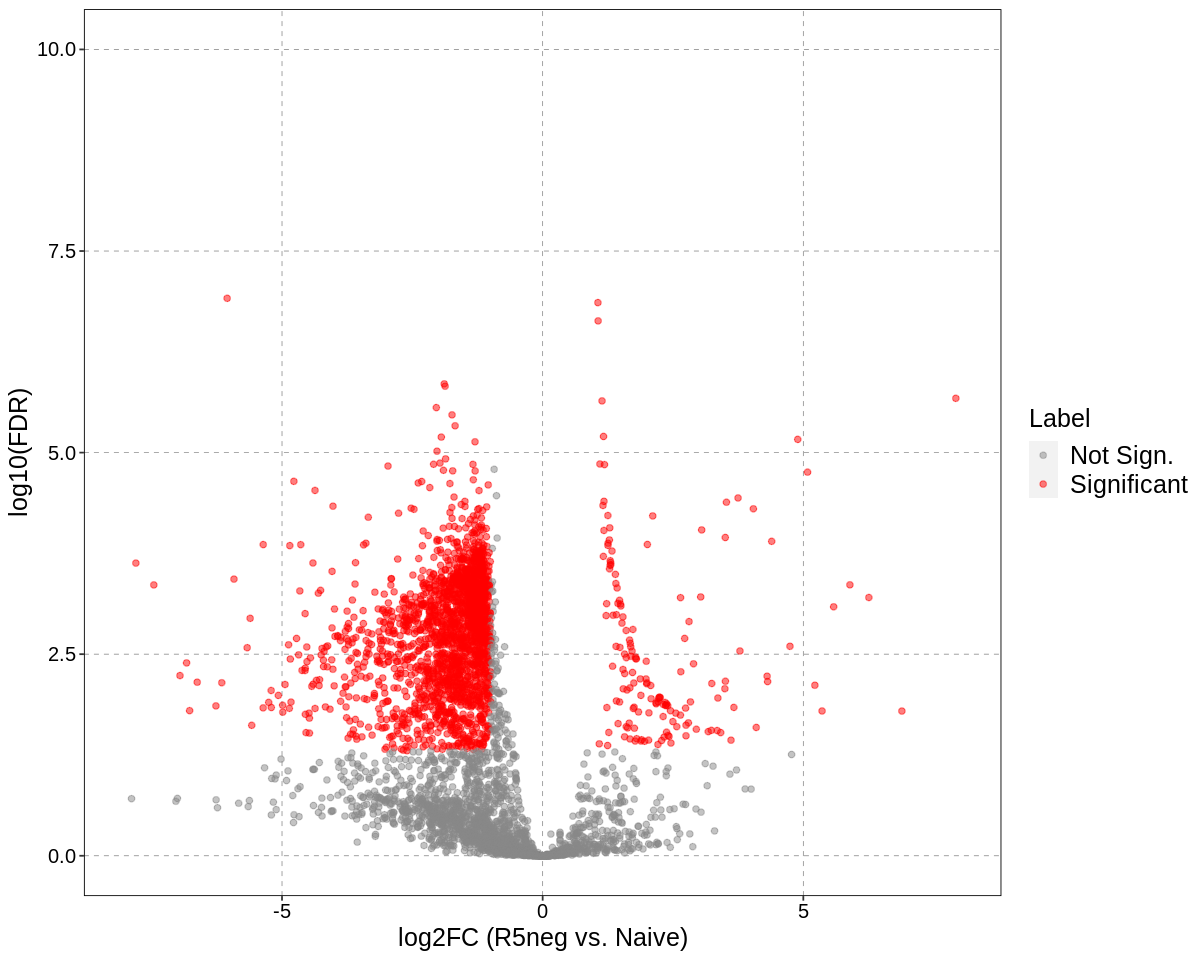

In [44]:
volcano_plot(res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight = FALSE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = 'contrast',
                show_plot = TRUE)

Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”


[1] "range of log10padj: 0\nrange of log2FC: Inf"                
[2] "range of log10padj: 6.91364711849783\nrange of log2FC: -Inf"
[1] "With highlighted text"


Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 131 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“ggrepel: 129 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


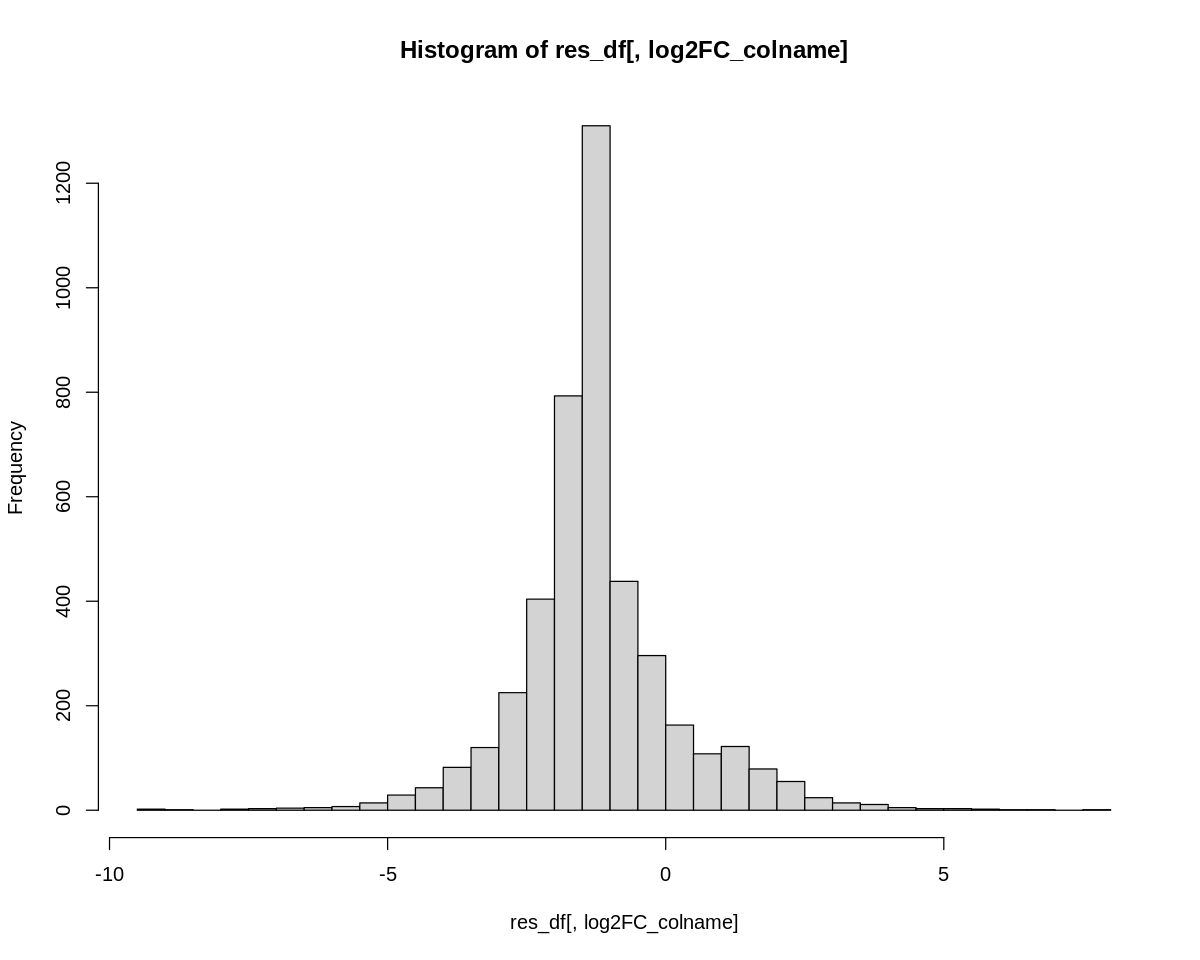

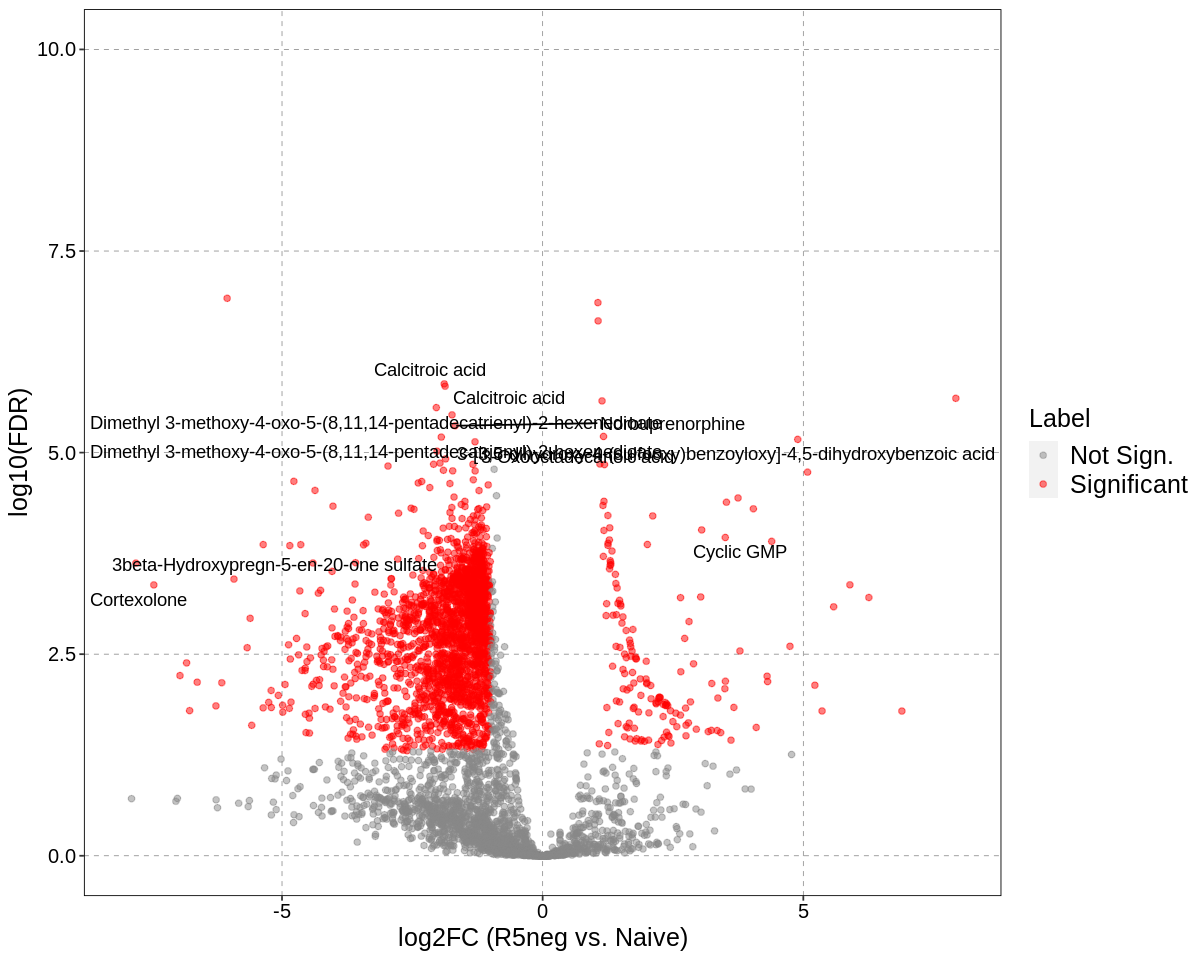

In [45]:
volcano_plot(   res_df = res_df,
                padj_colname = padj_colname,
                log2FC_colname = log2FC_colname,
                p_cut_off = 0.05,
                log2FC_cut_off = 1,
                xlab = glue("log2FC ({contrast})"),
                ylab = 'log10(FDR)',
                xlim = c(-8,8),
                ylim = c(0,10),
                highlight_text = TRUE,
                fig_width = 10,
                fig_height = 8,
                text_size = 12,
                legend_size = 15,
                axis_title_size = 15,
                output_dir = out_dir,
                pdf_prefix = glue('contrast',"highlight"),
                show_plot = TRUE)